<a href="https://colab.research.google.com/github/Wachacha-jay/Computer_vision_Image_classification/blob/main/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torchinfo

In [2]:
import os
from pathlib  import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm import tqdm

In [3]:
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)
print("torchinfo version : ", torchinfo.__version__)
print("numpy version : ", np.__version__)
print("matplotlib version : ", matplotlib.__version__)

!python --version

torch version :  2.6.0+cu124
torchvision version :  0.21.0+cu124
torchinfo version :  1.8.0
numpy version :  2.0.2
matplotlib version :  3.10.0
Python 3.11.13


In [4]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


In [5]:
!pip install kagglehub

# Upload your Kaggle API key (kaggle.json)
from google.colab import files
files.upload()  # Select your kaggle.json file

# Move the key to the correct directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [6]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("srg9000/cassava-plant-disease-merged-20192020")

print("Path to dataset files:", path)  # This will show where the dataset is stored

Path to dataset files: /kaggle/input/cassava-plant-disease-merged-20192020


In [7]:
import shutil
import os

# Copy the dataset to a new location
destination = "./cassava_dataset"
if not os.path.exists(destination):
    shutil.copytree(path, destination)
    print(f"Dataset copied to {destination}")
else:
    print(f"{destination} already exists")

Dataset copied to ./cassava_dataset


In [8]:
data_dir = Path(destination) / "merged_train.csv"

In [9]:
import pandas as pd
df = pd.read_csv(data_dir)
df.head()

,image_id,labels
0,723977410.jpg,3
1,3193577634.jpg,1
2,3349107107.jpg,3
3,2933959901.jpg,0
4,3020460837.jpg,4


In [10]:
labels_dict = {
    0: 'Cassava Bacterial Blight (CBB)',
    1: 'Cassava Brown Streak Disease (CBSD)',
    2: 'Cassava Green Mottle (CGM)',
    3: 'Cassava Mosaic Disease (CMD)',
    4: 'Healthy'
}

# Add a new column 'disease_name' by mapping 'labels' to 'labels_dict'
df['disease_name'] = df['labels'].map(labels_dict)

# Display the updated DataFrame
df.head()

,image_id,labels,disease_name
0,723977410.jpg,3,Cassava Mosaic Disease (CMD)
1,3193577634.jpg,1,Cassava Brown Streak Disease (CBSD)
2,3349107107.jpg,3,Cassava Mosaic Disease (CMD)
3,2933959901.jpg,0,Cassava Bacterial Blight (CBB)
4,3020460837.jpg,4,Healthy


In [11]:
train_path = os.path.join(destination, "train_images", "train_images")

In [12]:
import os
import shutil
import pandas as pd

# ===== CONFIGURATION =====
source_folder = train_path  # Folder containing all your images
destination_root = "train"        # Main folder to be created


# ===== FOLDER CREATION =====
# Create main folder and subfolders (with existence checks)
os.makedirs(destination_root, exist_ok=True)  # Main 'train' folder
print(f"✅ Created main folder: {destination_root}/")

for disease in labels_dict.values():
    subfolder = os.path.join(destination_root, disease)
    os.makedirs(subfolder, exist_ok=True)
    print(f"  ├── Created subfolder: {disease}/")

# ===== IMAGE ORGANIZATION =====
success_count = 0
missing_count = 0

for _, row in df.iterrows():
    src = os.path.join(source_folder, row['image_id'])
    dest = os.path.join(destination_root, labels_dict[row['labels']], row['image_id'])

    try:
        shutil.copy2(src, dest)  # copy2 preserves metadata
        success_count += 1
    except FileNotFoundError:
        print(f"⚠️ Missing: {row['image_id']}")
        missing_count += 1
    except Exception as e:
        print(f"❌ Error copying {row['image_id']}: {str(e)}")

# ===== RESULTS SUMMARY =====
print("\n📊 Organization Complete!")
print(f"✅ Successfully copied: {success_count} files")
print(f"⚠️  Missing files: {missing_count}")
print(f"📁 Final structure in: {os.path.abspath(destination_root)}/")

✅ Created main folder: train/
  ├── Created subfolder: Cassava Bacterial Blight (CBB)/
  ├── Created subfolder: Cassava Brown Streak Disease (CBSD)/
  ├── Created subfolder: Cassava Green Mottle (CGM)/
  ├── Created subfolder: Cassava Mosaic Disease (CMD)/
  ├── Created subfolder: Healthy/

📊 Organization Complete!
✅ Successfully copied: 27053 files
⚠️  Missing files: 0
📁 Final structure in: /content/train/


In [13]:
destination_path = Path("train")

Now that we have all or data in the train folder, we previously know that we hve an imbalanced data, now lets check the distribution of data in our directory

In [14]:
class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [15]:
transform = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [16]:
batch_size = 32
dataset = datasets.ImageFolder(destination_path, transform=transform)
dataloader = DataLoader(dataset=dataset, batch_size=batch_size)

In [17]:
#now lets count to evluate the distribution of our dat to perform undersampling
from collections import Counter
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    try:
        class_to_index = dataset.class_to_idx
    except AttributeError:
        class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

In [18]:
dataset_count = class_counts(dataset)
dataset_count

100%|██████████| 27053/27053 [03:08<00:00, 143.31it/s]


,0
Cassava Bacterial Blight (CBB),1553
Cassava Brown Streak Disease (CBSD),3632
Cassava Green Mottle (CGM),3159
Cassava Mosaic Disease (CMD),15816
Healthy,2893


## UNDERSAMPLING
Now we will create a new directory undasampled and store the images for the classes with the number of images in each class matching the class with the lowest number.

In [19]:
def undersample(dataset):
    dest = Path("undersampled")
    if dest.exists():
        shutil.rmtree(dest) # Remove existing undersampled directory
    dest.mkdir()

    min_count = dataset_count.min() # Get the count of the minority class

    # Create class directories in the undersampled folder
    for label in dataset_count.index:
        dest_folder = dest / label
        dest_folder.mkdir(parents=True, exist_ok=True)

    # Dictionary to keep track of copied images per class
    copied_counts = {label: 0 for label in dataset_count.index}

    # Iterate through the original dataset and copy images up to min_count
    for img_path, label_idx in tqdm(dataset.imgs):
        label_name = labels_dict[label_idx]
        if copied_counts[label_name] < min_count:
            img_filename = os.path.basename(img_path)
            dest_path = dest / label_name / img_filename
            shutil.copy2(img_path, dest_path)
            copied_counts[label_name] += 1

    print("\nUndersampling complete.")
    print("Copied image counts per class:")
    for label, count in copied_counts.items():
        print(f"- {label}: {count}")

In [20]:
undersample(dataset=dataset)

100%|██████████| 27053/27053 [00:08<00:00, 3305.59it/s] 


Undersampling complete.
Copied image counts per class:
- Cassava Bacterial Blight (CBB): 1553
- Cassava Brown Streak Disease (CBSD): 1553
- Cassava Green Mottle (CGM): 1553
- Cassava Mosaic Disease (CMD): 1553
- Healthy: 1553


Now we have our balanced dataset to use in our solution now lets go ahead

In [21]:
under = Path("undersampled")

In [22]:
dataset_under = datasets.ImageFolder(under, transform=transform)
dataloader_under = DataLoader(dataset=dataset_under, batch_size=batch_size)

In [23]:
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(dataloader_under):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5

    return mean, std


In [24]:
mean, std = get_mean_std(dataloader_under)

100%|██████████| 243/243 [00:53<00:00,  4.53it/s]


In [25]:
transform_norm = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [26]:
normalized_dataset = datasets.ImageFolder(under, transform=transform_norm)

Now that we have our undersample dataset, we will be splitting it into train and validation set, we will create the dataloaders and only shuffle true for train dataset

In [27]:
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(normalized_dataset, lengths = [0.8,0.2], generator=generator)
print("Length of training dataset:", len(train_dataset))
print("Length of validation dataset:", len(val_dataset))

percent_train = np.round(100 * len(train_dataset) / len(normalized_dataset), 2)
percent_val = np.round(100 * len(val_dataset) / len(normalized_dataset), 2)

print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val}% of full data")

Length of training dataset: 6212
Length of validation dataset: 1553
Train data is 80.0% of full data
Validation data is 20.0% of full data


In [28]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(type(train_loader))
print(type(val_loader))

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


## Model selection and transfer learning
We previously used a model architechture we had build but didnt like the perfomance, so now we will choose a pretrained model that has been trained on a wider dataset of images. This will bw resnet50

In [29]:
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 178MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [30]:
#now lets freeze the model parameters
for param in model.parameters():
    param.requires_grad = False

The only changes we will make to this is the output layer lets get the input features for us we only have five classes

In [31]:
in_feat = model.fc.in_features
in_feat

2048

In [32]:
#now lets create the output layer
modified_layer = nn.Sequential(
    nn.Linear(in_feat, 256),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(256, 5)
)
model.fc = modified_layer
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Now tht we are set with the model lets define the loss function and optimizer but this time we will be using a scheduler also we will implement early stopping for our training and checkpointing.

In [33]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [34]:
# Place model on device
model.to(device)
print(next(model.parameters()).device)

cuda:0


In [35]:
#lets check model summary
summary(model, input_size=(batch_size, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 5]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]   

In [36]:
from math import gamma
#We have so many parameters but luckily we will not be training the whole model now lets implement scheduler
step_size = 4
gamma = 0.2
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

For Early Stopping, we'll create a function early_stopping that we'll call from within the train function. The early_stopping function accepts:

The current validation loss,
The best validation loss so far
The number of epochs since validation loss last improved (counter).
In the function we need to check if validation loss improved. If yes, we reset the counter. If not, we add one to the counter. We also need to check if validation loss hasn't improved in the last 5 epochs. If that is the case, we should set stopping to True.

In [37]:
def early_stopping(validation_loss, best_val_loss, counter):
    if validation_loss < best_val_loss:
        best_val_loss = validation_loss
        counter = 0
    else:
        counter += 1

    if counter > 5:
        stopping = True
    else:
        stopping = False

    return counter, stopping

early_stopping?

Now we'll define a function that will take care of Checkpointing. In this function we need to check if validation loss improved. If yes, we save the model.

In [38]:
def checkpointing(validation_loss, best_val_loss, model, optimizer, save_path):
    if validation_loss < best_val_loss:
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": best_val_loss,
            },
            save_path,
        )
        print(f"Checkpoint saved with validation loss {validation_loss:.4f}")

## Training our model
lets modify our training function to have all of the above, we will pass our sceduler, early_stoping and checkpointing as optional prameters

In [40]:
from training import train_epoch, score

In [41]:
def train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=20,
    device="cpu",
    scheduler=None,
    checkpoint_path=None,
    early_stopping=None,
):
    # Track the model progress over epochs
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    learning_rates = []

    # Create the trackers if needed for checkpointing and early stopping
    best_val_loss = float("inf")
    early_stopping_counter = 0

    print("Model evaluation before start of training...")
    # Test on training set
    train_loss, train_accuracy = score(model, train_loader, loss_fn, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    # Test on validation set
    validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy)

    for epoch in range(1, epochs + 1):
        print("\n")
        print(f"Starting epoch {epoch}/{epochs}")

        # Train one epoch
        train_epoch(model, optimizer, loss_fn, train_loader, device)

        # Evaluate training results
        train_loss, train_accuracy = score(model, train_loader, loss_fn, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Test on validation set
        validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)
        val_losses.append(validation_loss)
        val_accuracies.append(validation_accuracy)

        print(f"Epoch: {epoch}")
        print(f"Training loss: {train_loss:.4f}")
        print(f"Training accuracy: {train_accuracy*100:.4f}%")
        print(f"Validation loss: {validation_loss:.4f}")
        print(f"Validation accuracy: {validation_accuracy*100:.4f}%")

        # # Log the learning rate and have the scheduler adjust it
        lr = optimizer.param_groups[0]["lr"]
        learning_rates.append(lr)
        if scheduler:
            scheduler.step()

        # Checkpointing saves the model if current model is better than best so far
        if checkpoint_path:
            checkpointing(
                validation_loss, best_val_loss, model, optimizer, checkpoint_path
            )

        # Early Stopping
        if early_stopping:
            early_stopping_counter, stop = early_stopping(
                validation_loss, best_val_loss, early_stopping_counter
            )
            if stop:
                print(f"Early stopping triggered after {epoch} epochs")
                break

        if validation_loss < best_val_loss:
            best_val_loss = validation_loss

    return (
        learning_rates,
        train_losses,
        val_losses,
        train_accuracies,
        val_accuracies,
        epoch,
    )

In [42]:
#Now lets train our model and we will set it to 30 epochs
epochs_to_train = 30

train_results = train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=epochs_to_train,
    device=device,
    scheduler=scheduler,
    checkpoint_path="TLmodel.pth",
    early_stopping=early_stopping,
)

(
    learning_rates,
    train_losses,
    valid_losses,
    train_accuracies,
    valid_accuracies,
    epochs,
) = train_results

Model evaluation before start of training...


Scoring:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/49 [00:00<?, ?it/s]



Starting epoch 1/30


Training:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 1
Training loss: 0.9879
Training accuracy: 63.0929%
Validation loss: 1.0410
Validation accuracy: 58.6735%
Checkpoint saved with validation loss 1.0410


Starting epoch 2/30


Training:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 2
Training loss: 0.8932
Training accuracy: 66.9231%
Validation loss: 1.0057
Validation accuracy: 60.7143%
Checkpoint saved with validation loss 1.0057


Starting epoch 3/30


Training:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 3
Training loss: 0.8054
Training accuracy: 69.6474%
Validation loss: 0.9982
Validation accuracy: 60.3316%
Checkpoint saved with validation loss 0.9982


Starting epoch 4/30


Training:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 4
Training loss: 0.7465
Training accuracy: 73.9583%
Validation loss: 0.9810
Validation accuracy: 61.2883%
Checkpoint saved with validation loss 0.9810


Starting epoch 5/30


Training:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 5
Training loss: 0.6920
Training accuracy: 75.3686%
Validation loss: 0.9557
Validation accuracy: 63.3929%
Checkpoint saved with validation loss 0.9557


Starting epoch 6/30


Training:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 6
Training loss: 0.6607
Training accuracy: 75.8173%
Validation loss: 0.9612
Validation accuracy: 62.8827%


Starting epoch 7/30


Training:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 7
Training loss: 0.6569
Training accuracy: 76.1378%
Validation loss: 0.9647
Validation accuracy: 62.2449%


Starting epoch 8/30


Training:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 8
Training loss: 0.6382
Training accuracy: 77.1474%
Validation loss: 0.9774
Validation accuracy: 62.7551%


Starting epoch 9/30


Training:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 9
Training loss: 0.6375
Training accuracy: 77.4840%
Validation loss: 0.9596
Validation accuracy: 62.7551%


Starting epoch 10/30


Training:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 10
Training loss: 0.6198
Training accuracy: 77.8686%
Validation loss: 0.9767
Validation accuracy: 61.8622%


Starting epoch 11/30


Training:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 11
Training loss: 0.6154
Training accuracy: 78.3013%
Validation loss: 0.9496
Validation accuracy: 63.5204%
Checkpoint saved with validation loss 0.9496


Starting epoch 12/30


Training:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 12
Training loss: 0.6239
Training accuracy: 77.8846%
Validation loss: 0.9974
Validation accuracy: 61.1607%


Starting epoch 13/30


Training:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 13
Training loss: 0.6205
Training accuracy: 78.3654%
Validation loss: 0.9760
Validation accuracy: 63.2015%


Starting epoch 14/30


Training:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 14
Training loss: 0.6127
Training accuracy: 78.0609%
Validation loss: 0.9609
Validation accuracy: 63.4566%


Starting epoch 15/30


Training:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 15
Training loss: 0.6076
Training accuracy: 78.5256%
Validation loss: 0.9759
Validation accuracy: 62.0536%


Starting epoch 16/30


Training:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 16
Training loss: 0.6125
Training accuracy: 78.5256%
Validation loss: 0.9514
Validation accuracy: 63.0102%


Starting epoch 17/30


Training:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/195 [00:00<?, ?it/s]

Scoring:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 17
Training loss: 0.6052
Training accuracy: 78.2853%
Validation loss: 0.9508
Validation accuracy: 63.3291%
Early stopping triggered after 17 epochs


In [51]:
checkpoint = torch.load("TLmodel.pth")

# Load the state dictionaries
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

In [52]:
# Evaluate the model on the validation set after loading the checkpoint
validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)
print(f"Validation loss after loading checkpoint: {validation_loss:.4f}")
print(f"Validation accuracy after loading checkpoint: {validation_accuracy*100:.4f}%")

Scoring:   0%|          | 0/49 [00:00<?, ?it/s]

Validation loss after loading checkpoint: 0.9496
Validation accuracy after loading checkpoint: 63.5204%


In [53]:
# Define the path to save the model
model_save_path = "cassava_disease_model.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to cassava_disease_model.pth


Lets plot and evaluate our losses

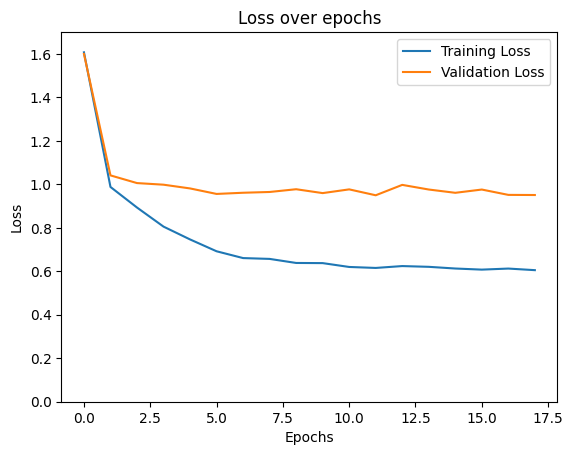

In [54]:
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.ylim([0, 1.7])
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

Next lets evaluate our accuracies

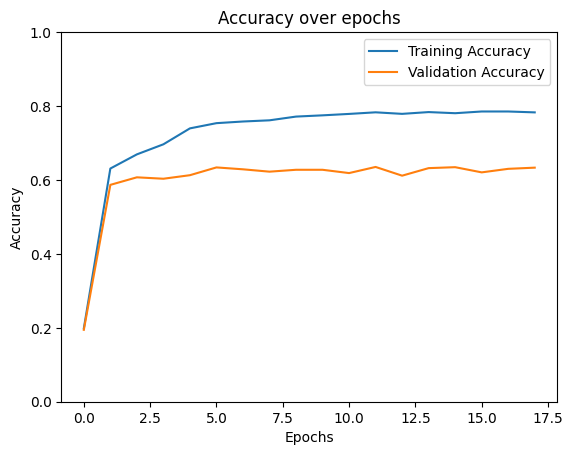

In [55]:
# Plot train accuracies, use label="Training Accuracy"
plt.plot(train_accuracies, label="Training Accuracy")
# Plot validation accuracies, use label="Validation Accuracy"
plt.plot(valid_accuracies, label="Validation Accuracy")
plt.ylim([0, 1])
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

Lets also investigate how our learning rates was changing with time

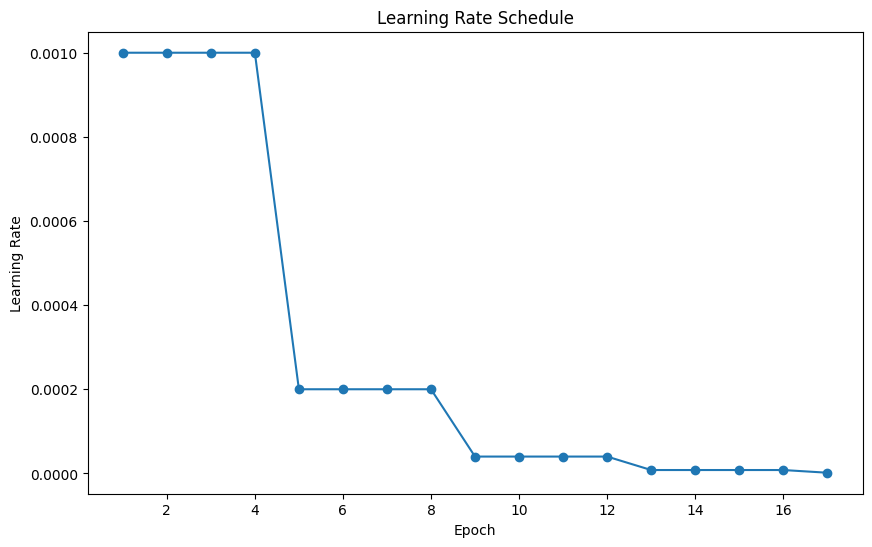

In [56]:
# Plot the learning rates
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), learning_rates, marker="o", label="Learning Rate")
plt.title("Learning Rate Schedule")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.show()

Now lets see how our model is doing and for these we will use our predict function to find the probabilities then argmax function to see the predicted classes then we will go ahead to create a confusion matrix to demonstrate our results

In [57]:
from training import predict
probabilities_val = predict(model,val_loader,device)
predictions_val = torch.argmax(probabilities_val, dim=1)

print(predictions_val)

Predicting:   0%|          | 0/49 [00:00<?, ?it/s]

tensor([2, 4, 0,  ..., 0, 3, 2], device='cuda:0')


In [63]:
dataset.classes

['Cassava Bacterial Blight (CBB)',
 'Cassava Brown Streak Disease (CBSD)',
 'Cassava Green Mottle (CGM)',
 'Cassava Mosaic Disease (CMD)',
 'Healthy']

Get Labels: 100%|██████████| 49/49 [00:12<00:00,  4.02it/s]


<Figure size 1000x800 with 0 Axes>

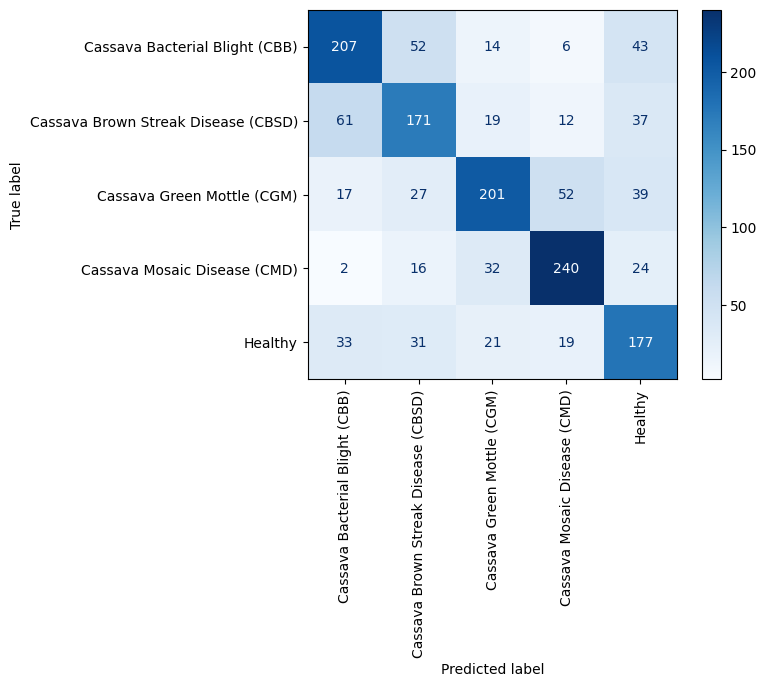

In [64]:
#Now lets get the target values and compute our confusion matrix
targets_val = torch.cat([labels for _, labels in tqdm(val_loader, desc="Get Labels")])

cm = confusion_matrix(targets_val.cpu(), predictions_val.cpu())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)

# Set figure size
plt.figure(figsize=(10, 8))

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical");

## CONCLUSION
We used Transfer Learning to take a large existing model and specialize it to our competition.
We trained that model with the balanced dataset we had created earlier.
We implemented Callbacks using additional code in the training loop.
The Callbacks we implemented were: Learning Rate Scheduling, Checkpointing, and Early Stopping.
With all the above modifications we can see that we have improved our model perfomance, although it is not still the best, but next we can try to augment our data instead of undersampling, so as to have a large dataset, which might consequently improve our perfomnce